In [16]:
import os
import numpy as np
import h5py
import trimesh
from tqdm import tqdm
import torch

def normalize_point_cloud(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    max_dist = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    pc = pc / max_dist
    return pc

def sample_point_cloud(obj_path, n_points=2048):
    mesh = trimesh.load(obj_path)
    points, _ = trimesh.sample.sample_surface(mesh, n_points)
    return normalize_point_cloud(points)

data_dir = "/kaggle/input/modelnet40"
output_dir = "/kaggle/working/modelnet40_2048"
os.makedirs(output_dir, exist_ok=True)

data, labels = [], []
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])


for cls_idx, cls_name in enumerate(tqdm(class_names, desc="处理数据")):
    cls_dir = os.path.join(data_dir, cls_name)
    for obj_file in os.listdir(cls_dir):
        if obj_file.endswith(".obj"):
            obj_path = os.path.join(cls_dir, obj_file)
            try:
                pc = sample_point_cloud(obj_path)
                data.append(pc)
                labels.append(cls_idx)
            except Exception as e:
                print(f"处理错误 {obj_path}: {e}")

if data:
    with h5py.File(os.path.join(output_dir, "train.h5"), "w") as f:
        f.create_dataset("data", data=np.array(data, dtype=np.float32))
        f.create_dataset("label", data=np.array(labels, dtype=np.int64))
    print(f"保存的训练数据长度: {len(data)} ，类别数： {len(class_names)} ")
else:
    raise ValueError("没有有效obj文件")



处理数据: 100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

保存的训练数据长度: 1000 ，类别数： 40 


In [17]:

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class PointNet(nn.Module):
    def __init__(self, num_classes=40):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x.transpose(1, 2)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.max(x, 2)[0]
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

class PointCloudDataset(Dataset):
    def __init__(self, h5_file):
        with h5py.File(h5_file, "r") as f:
            self.data = f["data"][:]
            self.labels = f["label"][:]
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

def train_pointnet(model, train_loader, epochs=100, lr=0.001):
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for P, y in train_loader:
            P, y = P.cuda(), y.cuda()
            optimizer.zero_grad()
            logits = model(P)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Acc: {correct/total:.4f}")
    
    torch.save(model.state_dict(), "/kaggle/working/pointnet.pth")

train_dataset = PointCloudDataset("/kaggle/working/modelnet40_2048/train.h5")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
victim_model = PointNet(num_classes=len(class_names))
train_pointnet(victim_model, train_loader)

victim_model.load_state_dict(torch.load("/kaggle/working/pointnet.pth"))
victim_model.eval()



Epoch 1/100, Loss: 3.6958, Acc: 0.0210
Epoch 2/100, Loss: 3.5240, Acc: 0.0560
Epoch 3/100, Loss: 3.1388, Acc: 0.0820
Epoch 4/100, Loss: 2.8711, Acc: 0.1360
Epoch 5/100, Loss: 2.6334, Acc: 0.2000
Epoch 6/100, Loss: 2.4798, Acc: 0.2270
Epoch 7/100, Loss: 2.3384, Acc: 0.2650
Epoch 8/100, Loss: 2.2318, Acc: 0.3130
Epoch 9/100, Loss: 2.1023, Acc: 0.3240
Epoch 10/100, Loss: 2.0487, Acc: 0.3560
Epoch 11/100, Loss: 1.9833, Acc: 0.3770
Epoch 12/100, Loss: 1.8982, Acc: 0.3850
Epoch 13/100, Loss: 1.8256, Acc: 0.4280
Epoch 14/100, Loss: 1.7693, Acc: 0.4410
Epoch 15/100, Loss: 1.6908, Acc: 0.4790
Epoch 16/100, Loss: 1.6399, Acc: 0.4670
Epoch 17/100, Loss: 1.6691, Acc: 0.4620
Epoch 18/100, Loss: 1.5398, Acc: 0.4850
Epoch 19/100, Loss: 1.4805, Acc: 0.5230
Epoch 20/100, Loss: 1.4251, Acc: 0.5410
Epoch 21/100, Loss: 1.3959, Acc: 0.5610
Epoch 22/100, Loss: 1.3307, Acc: 0.5630
Epoch 23/100, Loss: 1.2593, Acc: 0.5760
Epoch 24/100, Loss: 1.2385, Acc: 0.5810
Epoch 25/100, Loss: 1.1727, Acc: 0.6060
Epoch 26/

/tmp/ipykernel_31/4269049029.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  victim_model.load_state_dict(torch.load("/kaggle/working/pointnet.pth"))


PointNet(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=40, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [18]:
# FLAT 对抗攻击实现
def farthest_point_sampling(points, n_samples):
    """最远点采样 (FPS)"""
    batch_size, n_points, _ = points.shape
    centers = torch.zeros(batch_size, n_samples, 3, device=points.device)
    selected = torch.zeros(batch_size, n_samples, dtype=torch.long, device=points.device)
    
    idx = torch.randint(0, n_points, (batch_size,), device=points.device)
    centers[:, 0] = points[torch.arange(batch_size), idx]
    selected[:, 0] = idx
    
    for i in range(1, n_samples):
        dist = torch.cdist(points, centers[:, :i])  
        min_dist = torch.min(dist, dim=2)[0]  
        next_idx = torch.argmax(min_dist, dim=1)  
        centers[:, i] = points[torch.arange(batch_size), next_idx]
        selected[:, i] = next_idx
    return centers, selected

def compute_simplified_flux(P, V, centers, radius):
    """计算简化通量，确保与 V 的梯度追踪"""
    batch_size, n_points, _ = P.shape
    m = centers.shape[1]
    flux = torch.zeros(batch_size, m, device=P.device, requires_grad=False)  
    
    for b in range(batch_size):
        for i in range(m):
            center = centers[b, i]  
            dist = torch.norm(P[b] - center, dim=1)  
            mask = dist <= radius  
            region_points = P[b, mask]  
            region_vectors = V[b, mask]  
            
            if region_points.shape[0] == 0:
                flux[b, i] = 0.0
                continue
            
            # 计算通量，保留与 V 的计算图
            flux_region = torch.tensor(0.0, device=P.device)
            for j, Q in enumerate(region_points):
                sigma_Q = torch.norm(region_vectors[j])  # 扰动大小
                d_Q = region_vectors[j] / (sigma_Q + 1e-8)  # 单位方向
                n_Q = (Q - center) / (torch.norm(Q - center) + 1e-8)  # 法向量
                A_Q = sigma_Q / radius
                B_Q = torch.norm(Q - center)**2 / (radius**2 - torch.norm(Q - center)**2 + 1e-8)
                theta_Q = torch.acos(torch.clamp(torch.dot(d_Q, n_Q), -1.0, 1.0))
                flux_region = flux_region + A_Q * torch.sqrt(1 + B_Q * torch.cos(theta_Q)**2)
            flux[b, i] = flux_region  # 直接赋值，保留计算图
    return flux

def adjust_directions(P, V, centers, radius, flux, flux_threshold, alpha=0.02):
    """基于通量调整扰动方向"""
    batch_size, n_points, _ = P.shape
    m = centers.shape[1]
    V_new = V.clone()
    
    for b in range(batch_size):
        for i in range(m):
            center = centers[b, i]
            dist = torch.norm(P[b] - center, dim=1)
            mask = dist <= radius
            region_indices = torch.where(mask)[0]
            region_vectors = V_new[b, mask]  # [k, 3]
            
            if flux[b, i] > flux_threshold:
                # 确保 region_vectors 可微分
                region_vectors.requires_grad_(True)
                # 重新计算通量以连接计算图
                flux_value = torch.tensor(0.0, device=P.device, requires_grad=True)
                for j, Q in enumerate(P[b, mask]):
                    sigma_Q = torch.norm(region_vectors[j])
                    d_Q = region_vectors[j] / (sigma_Q + 1e-8)
                    n_Q = (Q - center) / (torch.norm(Q - center) + 1e-8)
                    A_Q = sigma_Q / radius
                    B_Q = torch.norm(Q - center)**2 / (radius**2 - torch.norm(Q - center)**2 + 1e-8)
                    theta_Q = torch.acos(torch.clamp(torch.dot(d_Q, n_Q), -1.0, 1.0))
                    flux_value = flux_value + A_Q * torch.sqrt(1 + B_Q * torch.cos(theta_Q)**2)
                
                flux_value.backward()  # 反向传播到 region_vectors
                grad = region_vectors.grad  
                if grad is None:
                    raise RuntimeError("计算梯度错误")
                with torch.no_grad():
                    for j, idx in enumerate(region_indices):
                        sigma = torch.norm(V_new[b, idx])
                        d_new = V_new[b, idx] - alpha * grad[j]
                        V_new[b, idx] = sigma * d_new / (torch.norm(d_new) + 1e-8)
                region_vectors.grad.zero_()
    return V_new

def flat_attack(model, P, y, epsilon=0.01, iterations=50, m=20, radius=0.1, alpha=0.02):
    """FLAT 对抗攻击"""
    P_adv = P.clone().detach().requires_grad_(True)
    batch_size = P.shape[0]
    
    for _ in range(iterations):
        # 1: 生成初始扰动 (IFGM)
        logits = model(P_adv)
        loss = F.cross_entropy(logits, y)
        grad = torch.autograd.grad(loss, P_adv, create_graph=False)[0]  
        V = epsilon * torch.sign(grad)  
        
        #  2: 基于通量调整方向
        centers, _ = farthest_point_sampling(P, m)  
        flux = compute_simplified_flux(P, V, centers, radius)  
        flux_threshold = torch.median(flux, dim=1)[0]  
        V = adjust_directions(P, V, centers, radius, flux, flux_threshold[0], alpha)
        
        # 3: 更新对抗点云
        with torch.no_grad():
            P_adv.data = P + V
            P_adv.data = torch.clamp(P_adv, P - epsilon, P + epsilon)
        
        # 检查攻击是否成功
        with torch.no_grad():
            if (model(P_adv).argmax(dim=1) != y).all():
                break
    
    return P_adv

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 攻击
P, y = next(iter(train_loader))
P, y = P.cuda(), y.cuda()
victim_model.cuda()
victim_model.eval()
P_adv = flat_attack(victim_model, P, y)

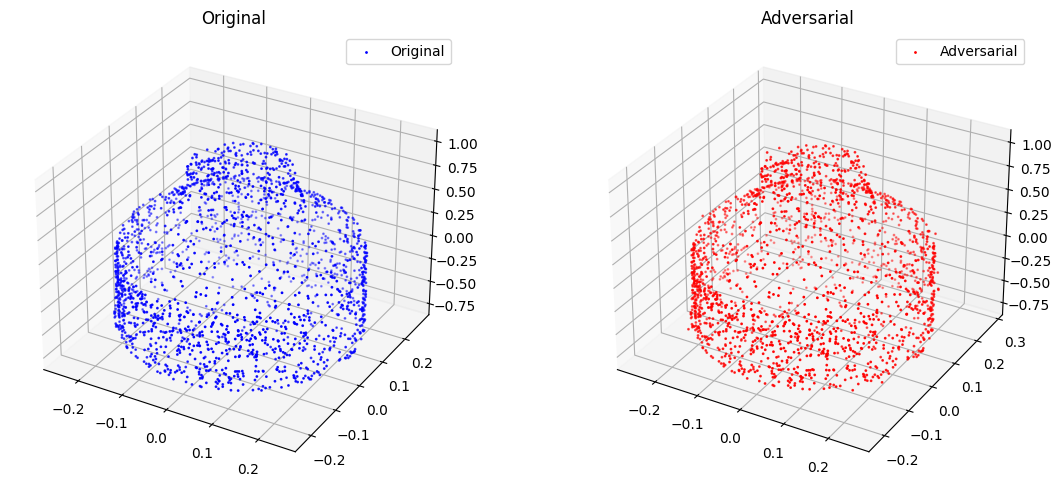

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_point_cloud(P, P_adv, sample_idx=0):
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121, projection="3d")
    ax2 = fig.add_subplot(122, projection="3d")
    
    P_np = P[sample_idx].detach().cpu().numpy()
    P_adv_np = P_adv[sample_idx].detach().cpu().numpy()
    
    
    ax1.scatter(P_np[:, 0], P_np[:, 1], P_np[:, 2], s=1, c='b', label="Original")
    ax2.scatter(P_adv_np[:, 0], P_adv_np[:, 1], P_adv_np[:, 2], s=1, c='r', label="Adversarial")
    
    ax1.set_title("Original")
    ax2.set_title("Adversarial")
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()


visualize_point_cloud(P, P_adv, sample_idx=0)